In [1]:
import numpy as np
import scanpy as sc
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:
adata = sc.read_h5ad("./data/subset_intestine.h5ad")
adata

AnnData object with n_obs × n_vars = 44084 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'sample_id', 'project_id', 'sample_type', 'tissue', 'anatomical_site', 'disease', 'platform', 'age_group', 'cell_sorting', 'treatment', 'subject_id', 'age', 'gender', 'rna_source', 'other_metadata'
    var: 'gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'project_id_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'data'

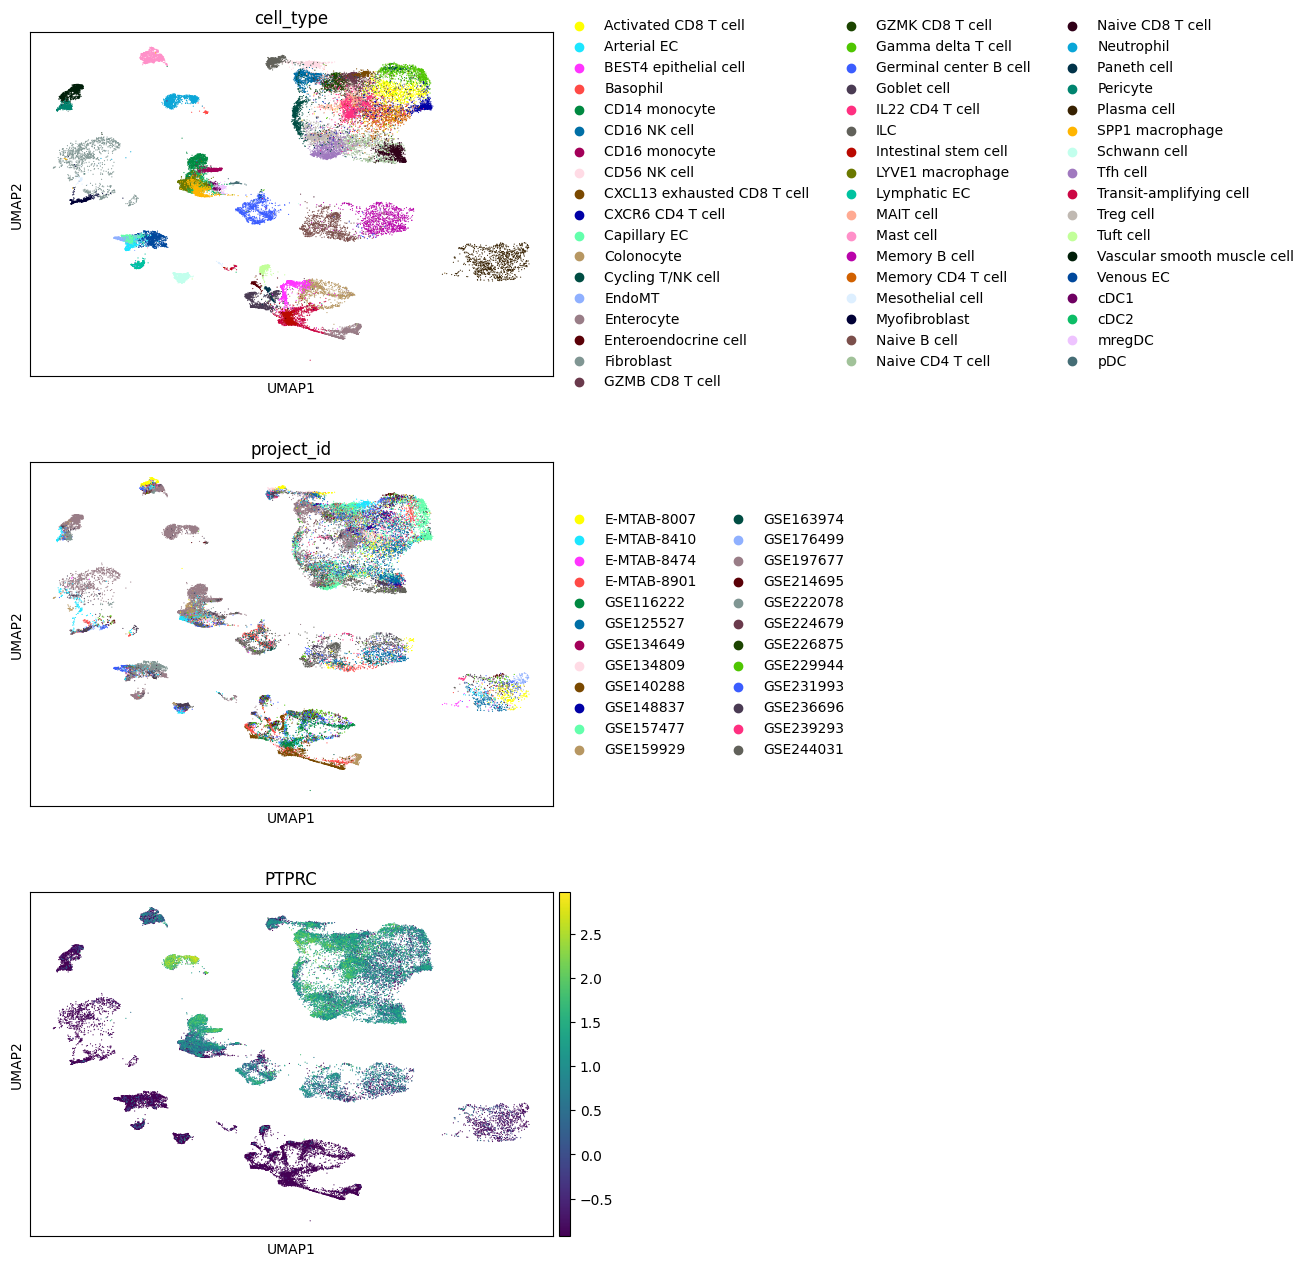

In [3]:
sc.pl.umap(adata,color=['cell_type','project_id','PTPRC'], palette=sc.pl.palettes.default_102,ncols=1)

In [3]:
highly_variable_genes = adata.var[adata.var['highly_variable']].index
X = adata[:, highly_variable_genes].X
# X = adata.X
y = adata.obs['cell_type'].values
le = LabelEncoder()
y = le.fit_transform(y)
# le.transorm can 
if hasattr(X,'toarray'):
    X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
else:
    X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
print(X_tensor.shape, y_tensor.shape)
# 将数据拆分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# 定义数据加载器
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

torch.Size([44084, 2000]) torch.Size([44084])


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 尝试导入 UMAP（如果安装了 umap-learn 包），否则用 TSNE
try:
    from umap import UMAP
    has_umap = True
except ImportError:
    has_umap = False

# ---------------------------
# 定义 VAE 模型（含分类分支）
# ---------------------------
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes):
        """
        参数说明：
          input_dim: 输入数据的维度（如基因表达数据维度）
          latent_dim: 隐层表示的维度
          num_classes: 细胞类型的类别数
        """
        super(VAE, self).__init__()
        # 编码器部分
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        # 解码器部分
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, input_dim)
        
        # 分类分支（直接从 latent 层预测细胞类型）
        self.classifier = nn.Linear(latent_dim, num_classes)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        recon_x = self.fc5(h4)
        # 如果数据归一化到 [0,1]，可考虑使用 Sigmoid 激活函数
        return recon_x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        # 分类分支直接从隐变量 z 预测细胞类型
        class_logits = self.classifier(z)
        return recon_x, mu, logvar, class_logits

# ---------------------------
# 定义损失函数
# ---------------------------
def loss_function(recon_x, x, mu, logvar, class_logits, target_labels,
                  mse_weight=1.0, kl_weight=0.1, ce_weight=1.0):
    """
    参数说明：
      recon_x: 模型重构的输出
      x: 原始输入
      mu, logvar: 隐层分布的参数
      class_logits: 分类分支输出（未经 softmax）
      target_labels: 真实细胞类型标签（LongTensor）
      mse_weight, kl_weight, ce_weight: 各项损失的权重
    """
    # 使用 mean 作为 reduction 计算 MSE 重构损失
    mse_loss = F.mse_loss(recon_x, x, reduction='mean')
    
    # 计算 KL 散度，并除以 batch_size 使其与其它损失在尺度上更接近
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    # 交叉熵损失，用于细胞类型分类
    ce_loss = F.cross_entropy(class_logits, target_labels, reduction='mean')
    
    total_loss = mse_weight * mse_loss + kl_weight * kl_loss + ce_weight * ce_loss
    return total_loss, mse_loss, kl_loss, ce_loss


# ---------------------------
# 可视化函数：展示 train 和 test 数据在隐层中的分布
# ---------------------------
def visualize_latent(model, train_loader, test_loader, device, method='tsne'):
    """
    参数说明：
      model: 训练好的 VAE 模型
      train_loader, test_loader: 数据加载器，每个 batch 返回 (x, labels)
      device: torch.device
      method: 降维方法，可选 'tsne' 或 'umap'
      
    如果 latent_dim > 2，则使用 TSNE/UMAP 降维，否则直接使用 latent 层二维数据。
    图中：颜色代表细胞类型；点的形状代表数据来源（圆形：train，三角形：test）。
    """
    model.eval()
    train_latents, train_labels = [], []
    test_latents, test_labels = [], []
    
    # 遍历 train_loader
    with torch.no_grad():
        for batch in train_loader:
            x, labels = batch
            x = x.to(device)
            _, mu, _, _ = model(x)
            train_latents.append(mu.cpu().numpy())
            train_labels.append(labels.cpu().numpy())
        for batch in test_loader:
            x, labels = batch
            x = x.to(device)
            _, mu, _, _ = model(x)
            test_latents.append(mu.cpu().numpy())
            test_labels.append(labels.cpu().numpy())
    
    train_latents = np.concatenate(train_latents, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_latents = np.concatenate(test_latents, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    
    latent_dim = train_latents.shape[1]
    
    # 如果隐层维度不为 2，则使用降维方法将其转为二维
    if latent_dim != 2:
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42)
        elif method.lower() == 'umap' and has_umap:
            reducer = UMAP(n_components=2, random_state=42)
        else:
            print("降维方法参数错误或UMAP未安装，默认使用 TSNE。")
            reducer = TSNE(n_components=2, random_state=42)
        # 为保证 train 和 test 在同一空间中，先将它们拼接后降维
        combined_latents = np.concatenate([train_latents, test_latents], axis=0)
        combined_embedded = reducer.fit_transform(combined_latents)
        train_embedded = combined_embedded[:train_latents.shape[0]]
        test_embedded = combined_embedded[train_latents.shape[0]:]
    else:
        train_embedded = train_latents
        test_embedded = test_latents
    
    # 绘图：不同颜色代表不同细胞类型，形状代表数据来源（训练/测试）
    plt.figure(figsize=(10, 8))
    
    # 获取所有细胞类型（假设标签为整数）
    all_labels = np.concatenate([train_labels, test_labels])
    unique_types = np.unique(all_labels)
    # 使用 tab10 作为配色方案
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_types)))
    type2color = {lab: colors[i] for i, lab in enumerate(unique_types)}
    
    # 为避免图例重复，我们分别存储绘制的 label 信息
    legend_elements = {}
    
    # 分别绘制 train 和 test 的数据点
    for lab in unique_types:
        # 训练数据点：圆形（'o'）
        idx_train = (train_labels == lab)
        if np.sum(idx_train) > 0:
            plt.scatter(train_embedded[idx_train, 0],
                        train_embedded[idx_train, 1],
                        marker='o',
                        color=type2color[lab],
                        edgecolor='k',
                        s=60,
                        label=f"Train: Type {lab}")
        # 测试数据点：三角形（'^'）
        idx_test = (test_labels == lab)
        if np.sum(idx_test) > 0:
            plt.scatter(test_embedded[idx_test, 0],
                        test_embedded[idx_test, 1],
                        marker='^',
                        color=type2color[lab],
                        edgecolor='k',
                        s=60,
                        label=f"Test: Type {lab}")
    
    plt.title("Latent Space Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

# ---------------------------
# 评估函数：计算 test_loader 上的细胞类型判别准确率
# ---------------------------
def evaluate_classification_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            x, labels = batch
            x = x.to(device)
            labels = labels.to(device)
            # 前向传播获取分类 logits（这里不需要重构信息）
            _, _, _, class_logits = model(x)
            predicted = class_logits.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total if total > 0 else 0.
    print(f"Test Classification Accuracy: {accuracy*100:.2f}%")
    return accuracy

In [5]:
# ---------------------------
# 主训练流程
# ---------------------------

# 输入数据维度、隐层维度和细胞类型数如下：
input_dim = X_tensor.shape[1]      # 例如：基因表达数据有1000个特征
latent_dim = 2       # 隐层维度（如果为2，则可直接用于可视化）
num_classes = len(adata.obs['cell_type'].unique())       # 细胞类型数，例如 5 类
print(f"input_dim: {input_dim}; latent_dim: {latent_dim}; num_classes: {num_classes}")

input_dim: 2000; latent_dim: 2; num_classes: 52


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建模型、优化器
model = VAE(input_dim, latent_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)


In [13]:
from torch.utils.tensorboard import SummaryWriter

num_epochs = 30
writer = SummaryWriter(log_dir='./runs/S-VAE_experiment')

model.train()
for epoch in range(num_epochs):
    epoch_total_loss = 0.0
    epoch_mse_loss = 0.0
    epoch_kl_loss = 0.0
    epoch_ce_loss = 0.0
    correct = 0
    total = 0
    
    for batch in train_loader:
        x, labels = batch
        x = x.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        recon_x, mu, logvar, class_logits = model(x)
        
        # 计算各项损失
        total_loss, mse_loss, kl_loss, ce_loss = loss_function(
            recon_x, x, mu, logvar, class_logits, labels,
            mse_weight=1.0, kl_weight=1, ce_weight=1.0)
        total_loss.backward()
        optimizer.step()
        
        # 累计损失值（这里每项损失都是单个 batch 的平均值）
        epoch_total_loss += total_loss.item()
        epoch_mse_loss   += mse_loss.item()
        epoch_kl_loss    += kl_loss.item()
        epoch_ce_loss    += ce_loss.item()
        
        # 计算分类准确率
        predicted = class_logits.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # 计算平均损失（每个 batch 的平均损失）
    avg_total_loss = epoch_total_loss / len(train_loader)
    avg_mse_loss   = epoch_mse_loss   / len(train_loader)
    avg_kl_loss    = epoch_kl_loss    / len(train_loader)
    avg_ce_loss    = epoch_ce_loss    / len(train_loader)
    train_accuracy = 100 * correct / total
    
    # Log 到 TensorBoard
    writer.add_scalar('Loss/train_total', avg_total_loss, epoch)
    writer.add_scalar('Loss/train_mse', avg_mse_loss, epoch)
    writer.add_scalar('Loss/train_kl', avg_kl_loss, epoch)
    writer.add_scalar('Loss/train_ce', avg_ce_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    
    # 打印各项损失和准确率
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {avg_total_loss:.4f}, "
          f"MSE: {avg_mse_loss:.4f}, KL: {avg_kl_loss:.4f}, CE: {avg_ce_loss:.4f}, "
          f"Accuracy: {train_accuracy:.2f}%")


Epoch [1/30], Total Loss: 4.9184, MSE: 1.0011, KL: 0.0213, CE: 3.8960, Accuracy: 2.66%
Epoch [2/30], Total Loss: 4.8779, MSE: 1.0014, KL: 0.0057, CE: 3.8708, Accuracy: 2.65%
Epoch [3/30], Total Loss: 4.8780, MSE: 1.0014, KL: 0.0046, CE: 3.8720, Accuracy: 2.67%
Epoch [4/30], Total Loss: 4.8777, MSE: 1.0011, KL: 0.0022, CE: 3.8745, Accuracy: 2.36%
Epoch [5/30], Total Loss: 4.8770, MSE: 1.0009, KL: 0.0035, CE: 3.8726, Accuracy: 2.42%
Epoch [6/30], Total Loss: 4.8770, MSE: 1.0008, KL: 0.0031, CE: 3.8731, Accuracy: 2.60%
Epoch [7/30], Total Loss: 4.8778, MSE: 1.0005, KL: 0.0023, CE: 3.8750, Accuracy: 2.28%
Epoch [8/30], Total Loss: 4.8780, MSE: 1.0021, KL: 0.0000, CE: 3.8758, Accuracy: 2.33%
Epoch [9/30], Total Loss: 4.8767, MSE: 1.0009, KL: 0.0001, CE: 3.8757, Accuracy: 2.16%
Epoch [10/30], Total Loss: 4.8797, MSE: 1.0036, KL: 0.0001, CE: 3.8760, Accuracy: 2.36%
Epoch [11/30], Total Loss: 4.8807, MSE: 1.0035, KL: 0.0001, CE: 3.8772, Accuracy: 2.12%
Epoch [12/30], Total Loss: 4.8793, MSE: 1

In [ ]:
# 训练结束后，可以使用测试数据（test_loader）和训练数据一起进行可视化，
# 这样可以直观地看到测试数据在训练构建的隐层图谱中的位置。
visualize_latent(model, train_loader, test_loader, device, method='tsne')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 简单 Autoencoder（无 VAE 部分，仅保留编码器、解码器和分类分支）
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes):
        super(Autoencoder, self).__init__()
        # 编码器部分
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_latent = nn.Linear(128, latent_dim)
        
        # 解码器部分
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, input_dim)
        
        # 分类分支：直接从 latent 层预测类别
        self.classifier = nn.Linear(latent_dim, num_classes)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        latent = self.fc_latent(h2)
        return latent
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        recon_x = self.fc5(h4)
        return recon_x
    
    def forward(self, x):
        latent = self.encode(x)
        recon_x = self.decode(latent)
        class_logits = self.classifier(latent)
        return recon_x, latent, class_logits

# 损失函数，只计算 MSE（重构）和 CE（分类）
def loss_function(recon_x, x, class_logits, target_labels, mse_weight=1.0, ce_weight=1.0):
    mse_loss = F.mse_loss(recon_x, x, reduction='mean')
    ce_loss = F.cross_entropy(class_logits, target_labels, reduction='mean')
    total_loss = mse_weight * mse_loss + ce_weight * ce_loss
    return total_loss, mse_loss, ce_loss

# 训练过程示例（略去数据加载等部分）
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='./runs/S-AE_experiment')



model = Autoencoder(input_dim, latent_dim, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    epoch_total_loss = 0.0
    epoch_mse_loss = 0.0
    epoch_ce_loss = 0.0
    correct = 0
    total = 0
    
    model.train()
    for batch in train_loader:
        x, labels = batch
        x = x.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        recon_x, latent, class_logits = model(x)
        total_loss, mse_loss, ce_loss = loss_function(recon_x, x, class_logits, labels,
                                                       mse_weight=1.0, ce_weight=1.0)
        total_loss.backward()
        optimizer.step()
        
        epoch_total_loss += total_loss.item()
        epoch_mse_loss   += mse_loss.item()
        epoch_ce_loss    += ce_loss.item()
        
        predicted = class_logits.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    avg_total_loss = epoch_total_loss / len(train_loader)
    avg_mse_loss = epoch_mse_loss / len(train_loader)
    avg_ce_loss = epoch_ce_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    writer.add_scalar('Loss/train_total', avg_total_loss, epoch)
    writer.add_scalar('Loss/train_mse', avg_mse_loss, epoch)
    writer.add_scalar('Loss/train_ce', avg_ce_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {avg_total_loss:.4f}, "
          f"MSE: {avg_mse_loss:.4f}, CE: {avg_ce_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


Epoch [1/30], Total Loss: 3.5702, MSE: 0.9113, CE: 2.6589, Accuracy: 25.23%
Epoch [2/30], Total Loss: 2.6848, MSE: 0.8689, CE: 1.8159, Accuracy: 49.47%
Epoch [3/30], Total Loss: 2.2889, MSE: 0.8666, CE: 1.4223, Accuracy: 60.98%
Epoch [4/30], Total Loss: 2.0204, MSE: 0.8590, CE: 1.1614, Accuracy: 68.51%
Epoch [5/30], Total Loss: 1.8524, MSE: 0.8695, CE: 0.9829, Accuracy: 73.81%
Epoch [6/30], Total Loss: 1.7400, MSE: 0.8835, CE: 0.8564, Accuracy: 77.09%
Epoch [7/30], Total Loss: 1.6368, MSE: 0.8926, CE: 0.7442, Accuracy: 80.42%
Epoch [8/30], Total Loss: 1.5488, MSE: 0.9031, CE: 0.6458, Accuracy: 82.59%
Epoch [9/30], Total Loss: 1.4933, MSE: 0.9131, CE: 0.5802, Accuracy: 84.67%
Epoch [10/30], Total Loss: 1.4317, MSE: 0.9190, CE: 0.5126, Accuracy: 86.13%
Epoch [11/30], Total Loss: 1.3665, MSE: 0.9180, CE: 0.4485, Accuracy: 88.11%
Epoch [12/30], Total Loss: 1.3518, MSE: 0.9184, CE: 0.4334, Accuracy: 88.99%
Epoch [13/30], Total Loss: 1.3366, MSE: 0.9251, CE: 0.4115, Accuracy: 89.49%
Epoch [1